In [1]:
from bs4 import BeautifulSoup
import re
import pandas as pd
from io import StringIO
import subprocess
from subprocess import check_output
from collections import Counter
import numpy as np
import time

In [2]:
#Q1
#adapted from https://scrapeops.io/python-web-scraping-playbook/python-beautifulsoup-find/
with open("sample.html") as fp:
    soup = BeautifulSoup(fp, "html.parser")
    
soup.find(string = re.compile("^contact")).getText()

'contact@example.com'

In [3]:
# adapted from https://stackoverflow.com/questions/50633050/scrape-tables-into-dataframe-with-beautifulsoup and 
# copied from https://stackoverflow.com/questions/45598443/strip-html-tags-findall-beautiful-soup
with open("rankings.html") as file:
    soup2 = BeautifulSoup(file, "html.parser")
    
table = soup2.find_all("table")
tableRows = soup2.find_all("tr")

res = []
for tr in tableRows:
    td = tr.find_all("td")
    row = [tr.text.strip() for tr in td if tr.text.strip()]
    if row:
        res.append(row)
        
cols = []
tableCols = soup2.find_all("th")
for c in tableCols:
    cols.append(str(c.text.strip()))
schoolsDF = pd.DataFrame(res, columns=cols)
schoolsDF.columns = [column.replace(" ", "_") for column in schoolsDF.columns] 
# schoolsDF

In [4]:
#Q2
# adapted from https://www.geeksforgeeks.org/pandas-query-method/
germanSchools = schoolsDF.query('Country == "Germany" and National_Rank == "1"')
# germanSchools
germanSchools.loc[:,"Institution"].to_string(index=False)


'Ludwig Maximilian University of Munich'

In [5]:
#Q3
usSchools = schoolsDF.query('Country == "USA" or Institution == "Ludwig Maximilian University of Munich"')
# copied from https://stackoverflow.com/questions/69746592/pandas-to-numeric
usSchools = usSchools.assign(World_Rank=pd.to_numeric(schoolsDF["World_Rank"]))

germanRank = usSchools.query('Country == "Germany" and National_Rank == "1"')
germanRank = int(germanRank.loc[:,"World_Rank"].to_string(index=False))
# germanRank


last10 = usSchools.query('World_Rank < @germanRank') 
list(last10.tail(10).loc[:,"Institution"])

['Duke University',
 'University of Illinois at Urbana–Champaign',
 'University of Washington - Seattle',
 'University of Wisconsin–Madison',
 'New York University',
 'University of Texas at Austin',
 'University of California, San Diego',
 'University of California, San Francisco',
 'University of North Carolina at Chapel Hill',
 'Dartmouth College']

In [6]:
#Q4
indiaRes = schoolsDF.query('Country == "India"')
indiaRes = indiaRes.assign(Research_Rank=pd.to_numeric(schoolsDF["Research_Rank"], errors='coerce')).dropna()
indiaRes = indiaRes.sort_values(by="Research_Rank")

list(indiaRes.head(5).loc[:,"Institution"])


['Indian Institute of Science',
 'Tata Institute of Fundamental Research',
 'Indian Institute of Technology Bombay',
 'Indian Institute of Technology Madras',
 'University of Delhi']

In [7]:
#Q5
# git checkout main
gitLog = str(check_output(["git", "log"], cwd="flask"), "utf-8").split("\n")
# gitLog
gitLog[0]

'commit 660994efc761efdfd49ca442b73f6712dc77b6cf'

In [8]:
#Q6
commits = []

for i in gitLog:
    if "commit " in i:
        commits.append(i[7:])
        if "commit" in i[7:]:
            commits.remove(i[7:])
        elif ")" in i[7:]:
            commits.remove(i[7:])
            
commits[-10:]
# commits

['a9d4ea81da28ee9c894bf9d45adc4cfa9d52fddc',
 '727c701686c18c4a27ca523eb0c5862d497be24e',
 '4edec48b74dbb9d571e927b69b24c30ec0624975',
 '625eba4bb403296a8bbc1e72cc9cf4a5126f6c02',
 '4aa76212d1be9b17a57249549c2a73fb10b6cda8',
 '3b36bef2e6165bb4dad73d17f23ee1879e99f497',
 '44b42e0fbd93d86e0f4e929bda8e5fb63e81035d',
 '4ec7d2a0d8eac4f915dc0d38a886cd57045bb0c4',
 'b15ad394279fc3b7f998fa56857f334a7c0156f6',
 '33850c0ebd23ae615e6823993d441f46d80b1ff0']

In [9]:
#Q7
#check_output(["git", "checkout", "main"], cwd="flask")
commit100 = commits[-100:-99]
#copied from https://www.geeksforgeeks.org/python-program-to-convert-a-list-to-string/
commit100 = ' '.join(commit100)
check_output(["git", "checkout", commit100], cwd="flask")

f=open("flask/README")
f.read()


Note: switching to 'f878919753a909e45b2d5448aa175f4f9129ff24'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at f8789197 With -> with in headline


"\n                          // Flask //\n\n         because sometimes a pocket knife is not enough\n\n\n    ~ What is Flask?\n\n      Flask is a microframework for Python based on Werkzeug\n      and Jinja2.  It's intended for small scale applications\n      and was development with best intentions in mind.\n\n    ~ Is it ready?\n\n      A preview release is out now, and I'm hoping for some\n      input about what you want from a microframework and\n      how it should look like.  Consider the API to slightly\n      improve over time.\n\n    ~ What do I need?\n\n      Jinja 2.4 and Werkzeug 0.6.1.  `easy_install` will\n      install them for you if you do `easy_install Flask==dev`.\n      I encourage you to use a virtualenv.  Check the docs for\n      complete installation and usage instructions.\n\n    ~ Where are the docs?\n\n      Go to http://flask.pocoo.org/ for a prebuild version of\n      the current documentation.  Otherwise build them yourself\n      from the sphinx sources i

In [10]:
#Q8
check_output(["git", "checkout", "main"], cwd="flask/")
logs = str(check_output(["git", "log"], cwd="flask/"), "utf-8").split("\n")
logs
authors = {}
pr = []
for i in logs:
    if "Merge pull request" in i:
        res = i.split('/')
        if "from" in i:
        #     #pr.append(res[0])
            pr.append(res[0][33:].replace(" ", ""))

#copied from https://www.geeksforgeeks.org/python-count-occurrences-element-list/ and https://stackoverflow.com/questions/48894060/how-to-print-the-value-of-a-specific-key-from-a-dictionary

d = Counter(pr)
for author in pr:
    x = pr.count(author)
    
for key,value in d.items():
    if value >= 10:
        authors[key] = value
authors

    


Previous HEAD position was f8789197 With -> with in headline
Switched to branch 'main'


{'pallets': 204,
 'pgjones': 14,
 'greyli': 42,
 'ThiefMaster': 11,
 'davidism': 45,
 'untitaker': 20,
 'ThomasWaldmann': 13,
 'SimonSapin': 11}

In [11]:
#Q9
# CalledProcessError 

try:
    msg = check_output(["pip3", "instal"], stderr=subprocess.STDOUT)
except subprocess.CalledProcessError as e:
    msg = e.output
msg.decode('utf_8')



'ERROR: unknown command "instal" - maybe you meant "install"\n'

Text(0.5, 1.0, 'Benchmarking: iterrows vs. itertuples')

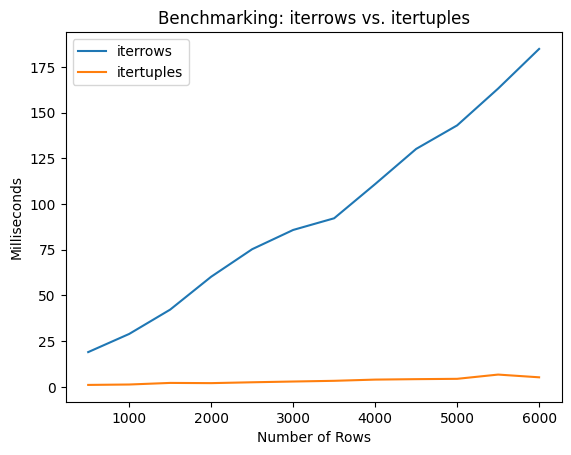

In [12]:
#Q10
def rand_df(rows):
    return pd.DataFrame(np.random.randint(10, size=(rows, 5)),
                        columns=["A", "B", "C", "D", "E"],
                        index=[f"r{i}" for i in range(1, rows+1)])

numRows = 500 
times_df = pd.DataFrame(dtype=float)
for i in range(12):
    df = rand_df(numRows)
    t0 = time.time()
    # HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
    for row in df.iterrows():
        pass
    t1 = time.time()
    # print((t1-t0) * 1e3)
    times_df.at[numRows, "iterrows"] = (t1-t0) * 1e3
    start = time.time()
    for row in df.itertuples():
            pass
    end = time.time()
    times_df.at[numRows, "itertuples"] = (end-start) * 1e3
    numRows += 500

plot = times_df.plot.line()
plot.set_xlabel("Number of Rows")
plot.set_ylabel("Milliseconds")
plot.set_title("Benchmarking: iterrows vs. itertuples")


Text(0.5, 1.0, 'Benchmarking: .loc vs. .at')

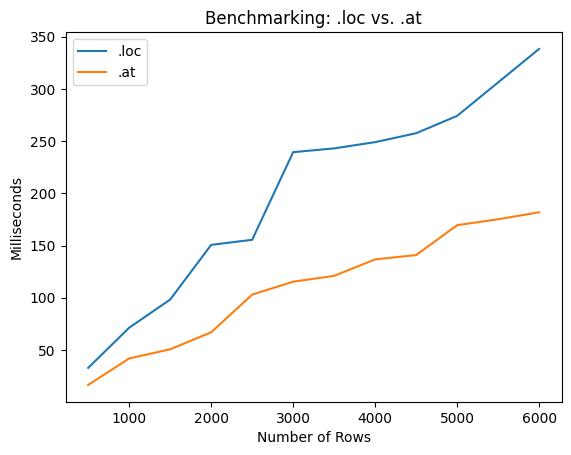

In [13]:
#Q11
def rand_df(rows):
    return pd.DataFrame(np.random.randint(10, size=(rows, 5)),
                        columns=["A", "B", "C", "D", "E"],
                        index=[f"r{i}" for i in range(1, rows+1)])

nRows = 500 
times_df = pd.DataFrame(dtype=float)
for i in range(12):
    df = rand_df(nRows)
    t0 = time.time()
    # HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
    total = 0
    for idx in df.index:
        for col in df.columns:
            total += df.loc[idx, col]
    t1 = time.time()
    # print((t1-t0) * 1e3)
    times_df.at[nRows, ".loc"] = (t1-t0) * 1e3
    start = time.time()
    # HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
    total = 0
    for idx in df.index:
        for col in df.columns:
            total += df.at[idx, col]
    end = time.time()
    times_df.at[nRows, ".at"] = (end-start) * 1e3
    nRows += 500

plot = times_df.plot.line()
plot.set_xlabel("Number of Rows")
plot.set_ylabel("Milliseconds")
plot.set_title("Benchmarking: .loc vs. .at")


Text(0.5, 1.0, 'Benchmarking: apply vs. loop')

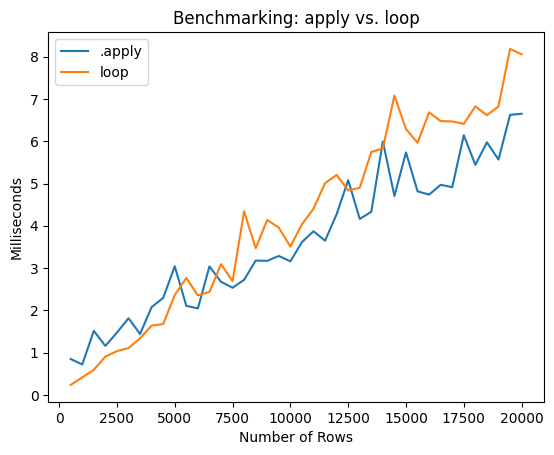

In [14]:
#Q12
def rand_df(rows):
    return pd.DataFrame(np.random.randint(10, size=(rows, 5)),
                        columns=["A", "B", "C", "D", "E"],
                        index=[f"r{i}" for i in range(1, rows+1)])
def laugh(x):
    return "qwerty" * x

nRows = 500 
times_df = pd.DataFrame(dtype=float)
for i in range(40):
    df = rand_df(nRows)
    t0 = time.time()
    # HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
    result = df["A"].apply(laugh).tolist()
    t1 = time.time()
    # print((t1-t0) * 1e3)
    times_df.at[nRows, ".apply"] = (t1-t0) * 1e3
    start = time.time()
    # HOW LONG DOES THIS TAKE TO RUN, FOR DATAFRAMES WITH DIFFERENT NUMBERS OF ROWS?
    result = []
    for val in df["A"]:
        result.append(laugh(val))
    end = time.time()
    times_df.at[nRows, "loop"] = (end-start) * 1e3
    nRows += 500

plot = times_df.plot.line()
plot.set_xlabel("Number of Rows")
plot.set_ylabel("Milliseconds")
plot.set_title("Benchmarking: apply vs. loop")